In [ ]:
# python 3.10.11

This file handles the ETL process from the TMDB API to a local SQLite database.  
The workflow follows the medallion architecture of bronze, silver and gold(optional) tables. 

In [2]:
# imports
import calendar
import json
import math
import os
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns; sns.set()

pd.set_option('display.max_columns', None) # show all columns of a dataframe
np.set_printoptions(threshold=np.inf) # remove limits on displaying numpy arrays
# pd.set_option('display.max_rows', None) # show all rows of a dataframe
# pd.set_option('display.max_colwidth', 10000) # show full width of dataframe columns

In [3]:
# variables
from dotenv import load_dotenv
load_dotenv('E:/CODING STUFF/# ALL_PROJECTS/YejiLab_final/backend/.env')
api_key = os.environ.get("API_KEY")
base_url = "https://api.themoviedb.org/3"
database = "kb_movies.db"

### Data Ingest

In [5]:
# Retrieve the list of all genres
params={
    "api_key": api_key
    }
response = requests.get(f"{base_url}/genre/movie/list", params=params)
data = response.json()
if response.status_code == 200:
    genre_list = data['genres']
else:
    print("Error", response.status_code, "\n", response.text)

df_genre = pd.DataFrame(genre_list)
display(df_genre)

,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [13]:
# Store in the database as genre_list table
with sqlite3.connect(database) as con:
    df_genre.to_sql('genre_list', con, if_exists='replace', index=False)

The TMDB API has a hard cap of 500 pages for any specific query.  
To circumvent the 500 page limit, we can specify one month at a time. From current year going back to 1870.  
<i>(the first movies are from the late 1800s: https://en.wikipedia.org/wiki/List_of_cinematic_firsts)</i>

In [ ]:
# Retrieve all movies from the discovery list by specifiying the year and the month.
# The range is from 1870 to current year.  (can take up to two hours to complete)

all_movies = []
year = datetime.today().year
# year_stop = 1870
year_stop = 2023


# This function finds the total page count for a given query.
# We find this value by making a query without specifying the page and retrieving 'total_pages' from the JSON response.
def find_page_count(year, month):
    last_day = calendar.monthrange(year, month)[1]
    params={
        "api_key": api_key,
        "year": year,
        "primary_release_date.gte": f"{year}-{month:02d}-01", 
        "primary_release_date.lte": f"{year}-{month:02d}-{last_day}" 
        }
    response = requests.get(f"{base_url}/discover/movie", params=params)
    data = response.json()
    if response.status_code == 200:
        return (data['total_pages'])
    else:
        print(f'Error {response.status_code}"\n"{response.text}')

# This function retrieves all movies for the specified month and year by looping through all the pages provided by the previous function
def total_movies_year_month(year, month):
    page_count = find_page_count(year, month)
    
    for i in range(1, page_count + 1):
        last_day = calendar.monthrange(year, month)[1]
        params={
            "api_key": api_key,
            "year": year,
            "page":i,
            "primary_release_date.gte": f"{year}-{month:02d}-01", 
            "primary_release_date.lte": f"{year}-{month:02d}-{last_day}" 
        }
        response = requests.get(f"{base_url}/discover/movie", params=params)
        data = response.json()
        if response.status_code == 200:
            if ('results' in data) and (data['results']):   # if there is a 'results' array in the json file and if that array is not empty
                for movie in data['results']:
                    title = movie.get('original_title', None)
                    genres = movie.get('genre_ids', None)
                    genres_name = [genre['name'] for genre in genre_list if genre['id'] in genres] # Convert the genre id to their associated names
                    release_date = movie.get('release_date', None)
                    rating = movie.get('vote_average', np.nan)
                all_movies.append([title, genres_name, release_date, rating])
        else:
            print(f'Error {response.status_code} at year {year}, month {month}, page {i}"\n"{response.text}')
            break

# Loop that calls our previous function for every month of every year.
while year >= year_stop:
    print(f'Retrieving for {year}')
    for month in range(12,0,-1):
        total_movies_year_month(year, month)
    year -= 1

print('Retrieval complete')

In [7]:
# Store the data in a dataframe
df = pd.DataFrame(all_movies)
df.columns=['title', 'genres', 'release_date', 'rating']

# convert the 'genres' column to concatenated strings rather than an array (this is because we cannot upload arrays to SQLite)
def flatten_array(cell):
    if isinstance(cell,list):
        return ', '.join(str(elem) for elem in cell)
    else:
        return str(cell)

df['genres'] = df['genres'].apply(flatten_array)

display(df)

,title,genres,release_date,rating
0,O Auto da Compadecida 2,Comedy,2024-12-25,0.0
1,與昆西的生活3,"Adventure, Animation, Comedy, Science Fiction",2024-12-24,0.0
2,Theseus,"Action, Adventure",2024-12-31,0.0
3,Fil Adımları,"Adventure, Drama",2024-12-21,0.0
4,#Rats,,2024-12-31,0.0
...,...,...,...,...
470,La Hess,Thriller,2024-01-03,0.0
471,Wisteria,Thriller,2024-01-19,0.0
472,I Would’ve Been Happy,Animation,2024-01-25,0.0
473,Dietroit,Drama,2024-01-07,0.0


In [19]:
# Save to local database as the bronze table
with sqlite3.connect(database) as con:
    df.to_sql('movies_bronze', con, if_exists='replace', index=False)

41807

### Data Cleaning

In [10]:
# Load the bronze table from the SQL database and store into a dataframe
with sqlite3.connect(database) as con:
    df = pd.read_sql_query("SELECT * FROM movies_bronze", con)


# display summary stats
display(df)
df.info()

# view null values
print('\nNull values :')
print(df.isna().sum())

# view number of duplicates
print('\nNumber of duplicates is:', df.duplicated().sum())


,title,genres,release_date,rating
0,The Magnificent Raiders of Dimension War One,Fantasy,2024-12-21,0.0
1,¿Quién es quién?,"Comedy, Family",2024-12-05,0.0
2,Dev 47,"Drama, Family",2024-12-20,0.0
3,Chemical India,Drama,2024-12-31,0.0
4,Al otro barrio,Comedy,2024-12-05,0.0
...,...,...,...,...
41802,1870,5,None,NaN
41803,1870,4,None,NaN
41804,1870,3,None,NaN
41805,1870,2,None,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41807 entries, 0 to 41806
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         41807 non-null  object 
 1   genres        41807 non-null  object 
 2   release_date  39947 non-null  object 
 3   rating        39947 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.3+ MB

Null values :
title              0
genres             0
release_date    1860
rating          1860
dtype: int64

Number of duplicates is: 0


In [11]:
# Drop all rows that have null values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True) # reset index
df.info()

# Some entries may not be null, but might instead contain ''. Let's look for those using a mask:
mask = (df == '').any(axis=1)
display(df[mask].eq('').sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39947 entries, 0 to 39946
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         39947 non-null  object 
 1   genres        39947 non-null  object 
 2   release_date  39947 non-null  object 
 3   rating        39947 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


title               0
genres          10013
release_date        0
rating              0
dtype: int64

After dropping all the detected nulls, there are still thousands of empty strings for the 'genres' column.   
Rather than remove those rows, let's replace the empty strings with something more descriptive such as the word '_Unknown'. (we add the underscore to make sure it shows as the last column.)

In [12]:
# Replace every occurence of '' with 'Unknown'
df['genres'] = df['genres'].replace('', '_Unknown')

# verify the replacement was successful
display(df[mask].eq('').sum())

title           0
genres          0
release_date    0
rating          0
dtype: int64

In [47]:
# Save to local database as the silver table 
with sqlite3.connect(database) as con:
    df.to_sql('movies_silver', con, if_exists='replace', index=False)


(Optional) Assuming this pipeline involves data analysts and data scientists, I can further refine the table to make it easy for aggregations and machine learning tasks.  
Let's perform one-hot encoding on the 'genres' column.

In [4]:
# Load the silver table into a dataframe
with sqlite3.connect(database) as con:
    df = pd.read_sql_query("SELECT * FROM movies_silver", con)


# Perform one hot encoding on the 'genres' column
df2 = df['genres'].str.split(',').explode().str.strip().str.get_dummies().groupby(level=0).sum() # when creating the dummies, we also need to group the categories and strip the whitespaces.
df = pd.concat([df,df2], axis=1) # join the new dataframe to the initial one

# drop the redundant 'genres' column
df = df.drop('genres', axis=1)

display(df)

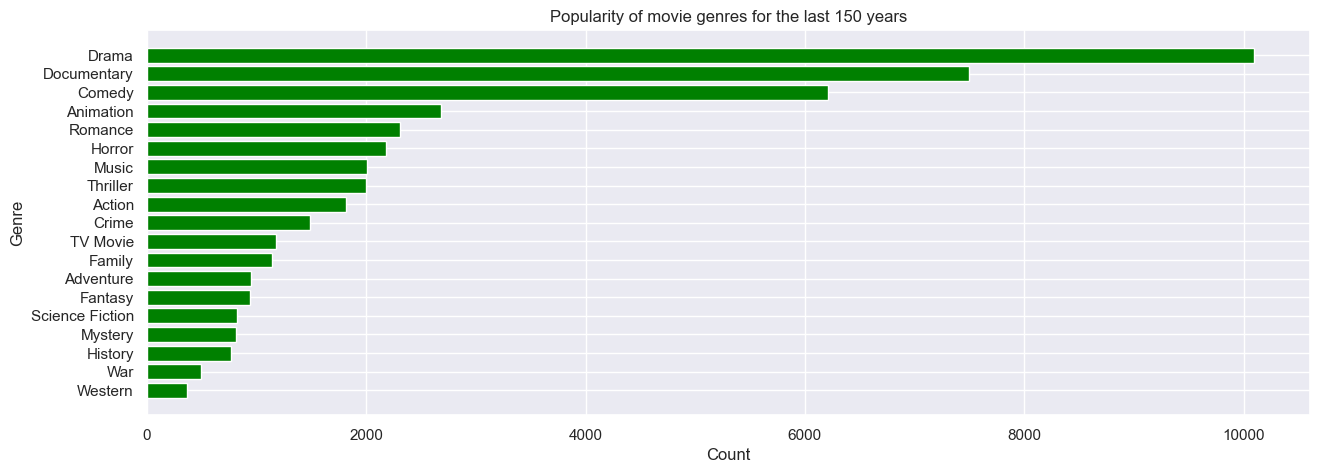

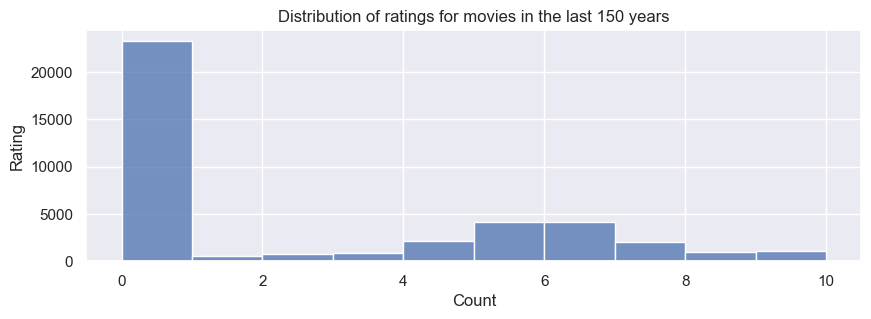

In [14]:
# We can now perform a more thorough EDA
sum_genres = df.iloc[:, 3:(df.shape[1]-1)].sum(axis=0).sort_values(ascending=True)   # Select all genres by selecting the 4th column until the second to last (we want to exclude the last column which is '_Unknown')
_=plt.figure(figsize=(15, 5)) 
_=plt.barh(sum_genres.index, sum_genres.values, color='green')
_=plt.xlabel('Count')
_=plt.ylabel('Genre')
_=plt.title('Popularity of movie genres for the last 150 years')

_=plt.figure(figsize=(10, 3)) 
_=sns.histplot(df['rating'], bins=10)
_=plt.xlabel('Count')
_=plt.ylabel('Rating')
_=plt.title('Distribution of ratings for movies in the last 150 years')

Ignoring the unknowns, the most popular movie genre is Drama.  
It also seems like we have a lot of null values for ratings, they could be missing entries.  
Let's view the rating distribution again without the zeroes.

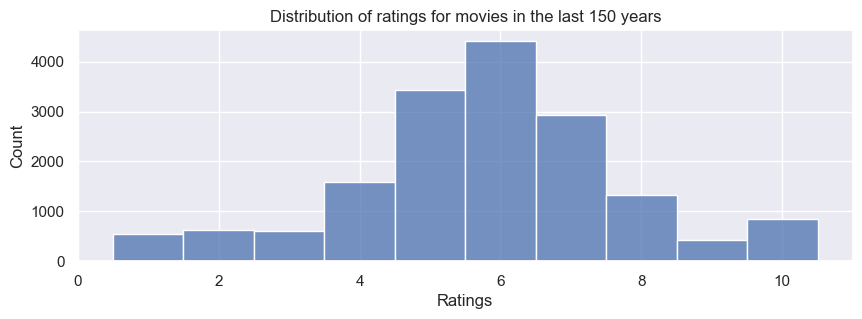

In [56]:
_=plt.figure(figsize=(10, 3)) 
_=sns.histplot(df.loc[df['rating'] > 0, 'rating'], bins=10, binwidth=1)
_=plt.xlabel('Ratings')
_=plt.ylabel('Count')
_=plt.title('Distribution of ratings for movies in the last 150 years')

We see now that the ratings follow a bell curve. Let's save this new table as a gold table.

In [57]:
# Save to local database as a gold table
with sqlite3.connect(database) as con:
    df.to_sql('movies_gold', con, if_exists='replace', index=False)

Lastly, let's add an empty bookmarks table to the databse. It will be populated by the API calls from our Flask app.

In [22]:
# Make an empty bookmarks table:
with sqlite3.connect(database) as con:
    df = pd.DataFrame(columns=['title', 'genres', 'release_date', 'rating'])
    df.to_sql('movies_bookmarks', con, if_exists='ignore', index=False)

In [25]:
# # View bookmarks table

# database ='kb_movies.db'
# with sqlite3.connect(database) as con:
#     df_bookmarks = pd.read_sql_query(f'''
#         SELECT * 
#         FROM movies_bookmarks;
#     ''',con)
# display(df_bookmarks)

,title,genres,release_date,rating


In [18]:
# Drop the bookmarks table
# with sqlite3.connect(database) as con:
#     con.execute(f'''
#         DROP TABLE IF EXISTS movies_bookmarks
#         ''')